# Les imports 

In [2]:
# --- Notebook : Modèle Linéaire - Cas de Tests de Régression ---
import ctypes
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# === Chargement de la bibliothèque Rust compilée ===
lib = ctypes.CDLL("../../../target/release/mymodel.dll")

In [4]:
# === Classification binaire par moindres carrés ===

lib.create_linear_model_least_squares.argtypes = [
    ctypes.POINTER(ctypes.c_double),   # x_ptr
    ctypes.POINTER(ctypes.c_double),   # y_ptr
    ctypes.c_size_t,                   # n_samples
    ctypes.c_size_t                    # n_features
]
lib.create_linear_model_least_squares.restype = ctypes.c_void_p

lib.predict_linear_model_least_squares_with_activation.argtypes = [
    ctypes.c_void_p,                   # model_ptr
    ctypes.POINTER(ctypes.c_double),  # x_ptr
    ctypes.c_size_t,                  # n_features
    ctypes.c_uint                     # activation_id (0=sigmoid, 1=tanh, 2=relu)
]
lib.predict_linear_model_least_squares_with_activation.restype = ctypes.c_double


## Classification binaire

### Linear Simple :
        Linear Model : OK
   
        


 Précision : 100.00%

 Prédictions LinearModel (tanh) :
[1.0, 1.0] → attendu : 1, sortie : 0.762 → classe prédite : 1
[2.0, 3.0] → attendu : -1, sortie : -0.762 → classe prédite : -1
[3.0, 3.0] → attendu : -1, sortie : -0.762 → classe prédite : -1


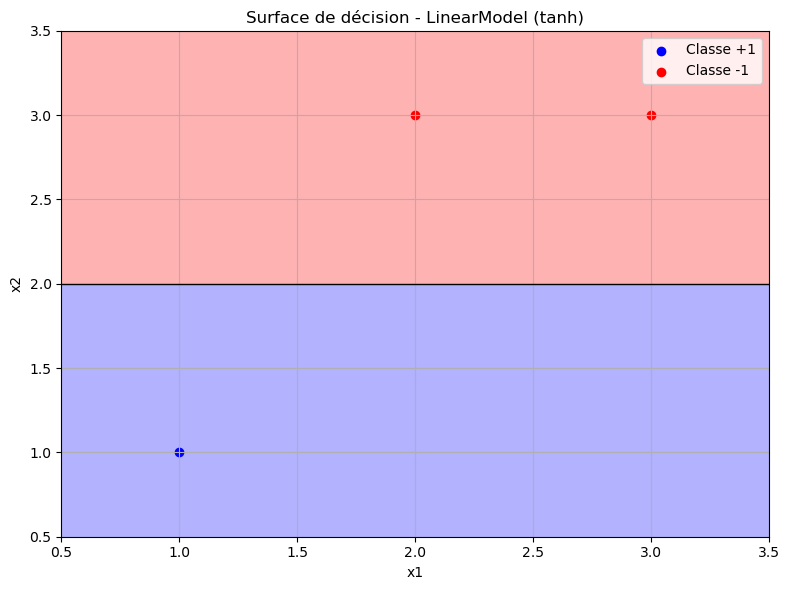

In [7]:
# === Données ===
X = np.array([
    [1, 1],
    [2, 3],
    [3, 3]
], dtype=np.float64)

Y = np.array([1, -1, -1], dtype=np.float64)

n_samples, n_features = X.shape


# === Création du modèle Least Squares ===
X_flat = X.flatten()
Y_flat = Y

model_ptr = lib.create_linear_model_least_squares(
    X_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    Y_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    n_samples,
    n_features
)

# === Fonction de prédiction avec activation tanh (id = 1)
def predict(x):
    x_np = np.array(x, dtype=np.float64)
    return lib.predict_linear_model_least_squares_with_activation(
        model_ptr,
        x_np.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        len(x_np),
        1  # Activation tanh
    )

# === Prédictions
Y_pred_continuous = np.array([predict(xi) for xi in X])
Y_pred_binary = (Y_pred_continuous >= 0).astype(np.uint32)
Y_true_binary = (Y == 1).astype(np.uint32)

accuracy = (Y_pred_binary == Y_true_binary).sum() / len(Y)

print(f"\n Précision : {accuracy * 100:.2f}%\n")
print(" Prédictions LinearModel (tanh) :")
for xi, yi, yhat in zip(X, Y, Y_pred_continuous):
    classe_pred = 1 if yhat >= 0 else -1
    print(f"{xi.tolist()} → attendu : {int(yi)}, sortie : {yhat:.3f} → classe prédite : {classe_pred}")

# === Visualisation de la surface de décision
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([predict(pt) for pt in grid])
Z = Z.reshape(xx.shape)

# === Affichage
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.3, colors=["red", "blue"])
plt.contour(xx, yy, Z, levels=[0], colors="black", linewidths=1)

# Affichage des points par classe
plt.scatter(X[Y == 1][:, 0], X[Y == 1][:, 1], color='blue', label='Classe +1')
plt.scatter(X[Y == -1][:, 0], X[Y == -1][:, 1], color='red', label='Classe -1')

plt.title("Surface de décision - LinearModel (tanh)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Linear Multiple :
        Linear Model : OK
        

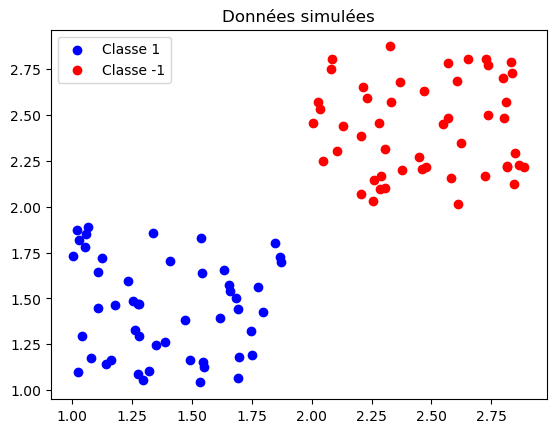

Précision : 100.00%
Prédictions LinearModel (tanh) :
[1.3370861069626263, 1.8556428757689245] → attendu : 1, sortie : 0.523 → classe prédite : 1
[1.6587945476302646, 1.538792635777333] → attendu : 1, sortie : 0.526 → classe prédite : 1
[1.140416776398193, 1.1403950683025823] → attendu : 1, sortie : 0.880 → classe prédite : 1
[1.0522752509513795, 1.7795585311974418] → attendu : 1, sortie : 0.712 → classe prédite : 1
[1.541003510568888, 1.637265320016441] → attendu : 1, sortie : 0.536 → classe prédite : 1
[1.0185260448662221, 1.872918866945795] → attendu : 1, sortie : 0.684 → classe prédite : 1
[1.7491983767203796, 1.1911051996104485] → attendu : 1, sortie : 0.671 → classe prédite : 1
[1.1636424704863906, 1.1650640588680905] → attendu : 1, sortie : 0.871 → classe prédite : 1
[1.273818018663584, 1.4722807884690141] → attendu : 1, sortie : 0.749 → classe prédite : 1
[1.3887505167779042, 1.2621062261782376] → attendu : 1, sortie : 0.785 → classe prédite : 1
[1.5506676052501416, 1.1255444745

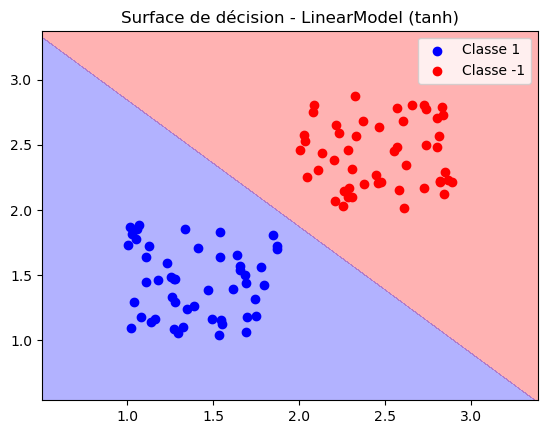

<Figure size 640x480 with 0 Axes>

In [5]:
# === Données : 2 clusters autour de [1,1] (classe 1) et [2,2] (classe -1)
np.random.seed(42)  # pour reproductibilité

X = np.concatenate([
    np.random.random((50, 2)) * 0.9 + np.array([1, 1]),
    np.random.random((50, 2)) * 0.9 + np.array([2, 2])
])
Y = np.concatenate([
    np.ones((50, 1)),
    -1.0 * np.ones((50, 1))
]).flatten()  

# Affichage initial
plt.scatter(X[0:50, 0], X[0:50, 1], color='blue', label='Classe 1')
plt.scatter(X[50:100, 0], X[50:100, 1], color='red', label='Classe -1')
plt.title("Données simulées")
plt.legend()
plt.show()
plt.clf()
n_samples, n_features = X.shape

# === Créer le modèle 
X_flat = X.flatten()
Y_flat = Y

model_ptr = lib.create_linear_model_least_squares(
    X_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    Y_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    n_samples,
    n_features
)

# === prédiction
activation_id = 1

Y_pred = np.array([
    lib.predict_linear_model_least_squares_with_activation(
        model_ptr,
        row.astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        n_features,
        activation_id
    )
    for row in X
])

# === Fonction de prédiction
def predict(x):
    x_np = np.array(x, dtype=np.float64)
    return lib.predict_linear_model_least_squares_with_activation(
        model_ptr,
        x_np.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        len(x_np),
        1  # tanh
    )
# Prédiction sur l’ensemble
Y_pred = np.array([predict(row) for row in X])
Y_true = (Y == 1).astype(np.uint32)
Y_pred_binary = (Y_pred >= 0).astype(np.uint32)

accuracy = (Y_true == Y_pred_binary).sum() / len(Y_true)
print(f"Précision : {accuracy * 100:.2f}%")

print("Prédictions LinearModel (tanh) :")
Y_pred = []
for xi, yi in zip(X, Y):
    out = predict(xi)
    classe = 1 if out >= 0 else 0
    Y_pred.append(out)
    print(f"{xi.tolist()} → attendu : {int(yi)}, sortie : {out:.3f} → classe prédite : {classe}")
    
# === Visualisation de la surface de décision
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([predict(pt) for pt in grid])
Z = Z.reshape(xx.shape)

# === Affichage
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.3, colors=["red", "blue"])
plt.scatter(X[0:50, 0], X[0:50, 1], color='blue', label='Classe 1')
plt.scatter(X[50:100, 0], X[50:100, 1], color='red', label='Classe -1')
plt.title("Surface de décision - LinearModel (tanh)")
plt.legend()
plt.show()
plt.clf()


### XOR :
        Linear Model    : OK

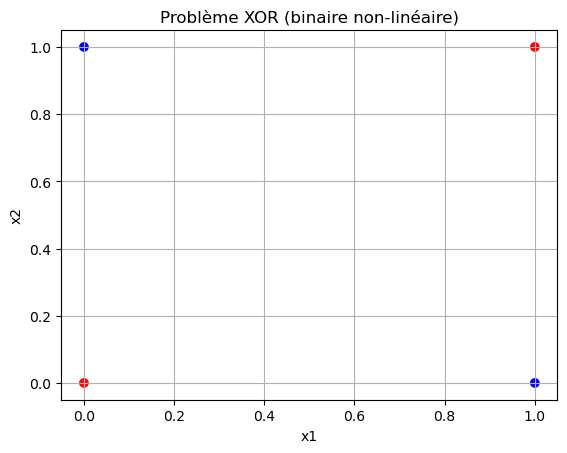

Précision : 50.00%
Prédictions LinearModel (tanh) :
[0.0, 0.0] → attendu : -1, sortie : 0.000 → classe prédite : 1
[0.0, 1.0] → attendu : 1, sortie : 0.000 → classe prédite : 1
[1.0, 0.0] → attendu : 1, sortie : 0.000 → classe prédite : 1
[1.0, 1.0] → attendu : -1, sortie : 0.000 → classe prédite : 1


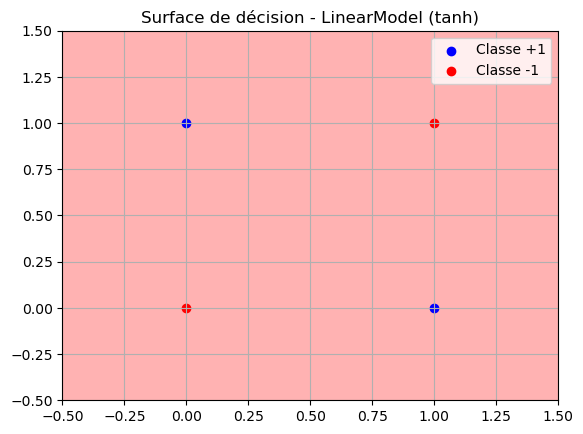

In [ ]:
# === Données du problème XOR
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
], dtype=np.float64)

Y = np.array([
    -1,  # 0 XOR 0 = 0 → -1
    1,   # 0 XOR 1 = 1 → +1
    1,   # 1 XOR 0 = 1 → +1
    -1   # 1 XOR 1 = 0 → -1
], dtype=np.float64)

# === Affichage des points
colors = ['red' if y == -1 else 'blue' for y in Y]
plt.scatter(X[:, 0], X[:, 1], c=colors)
plt.title("Problème XOR (binaire non-linéaire)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.show()
plt.clf()

n_samples, n_features = X.shape
# === Créer le modèle 
X_flat = X.flatten()
Y_flat = Y

model_ptr = lib.create_linear_model_least_squares(
    X_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    Y_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    n_samples,
    n_features
)

# == prédiction 
activation_id = 1

Y_pred = np.array([
    lib.predict_linear_model_least_squares_with_activation(
        model_ptr,
        row.astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        n_features,
        activation_id
    )
    for row in X
])
# Fonction de prédiction
def predict(x):
    x_np = np.array(x, dtype=np.float64)
    return lib.predict_linear_model_least_squares_with_activation(
        model_ptr,
        x_np.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        len(x_np),
        1  # tanh
    )

# Prédictions et évaluation
Y_pred = np.array([predict(row) for row in X])
Y_true = (Y == 1).astype(np.uint32)
Y_pred_binary = (Y_pred >= 0).astype(np.uint32)

accuracy = (Y_true == Y_pred_binary).sum() / len(Y_true)
print(f"Précision : {accuracy * 100:.2f}%")

# prédiction sur tous les points
print("Prédictions LinearModel (tanh) :")
Y_pred = []
for xi, yi in zip(X, Y):
    out = predict(xi)
    classe = 1 if out >= 0 else 0
    Y_pred.append(out)
    print(f"{xi.tolist()} → attendu : {int(yi)}, sortie : {out:.3f} → classe prédite : {classe}")

# Surface de décision
x_min, x_max = -0.5, 1.5
y_min, y_max = -0.5, 1.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([predict(pt) for pt in grid]).reshape(xx.shape)

# === Visualisation
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.3, colors=["red", "blue"])
plt.scatter(X[Y == 1][:, 0], X[Y == 1][:, 1], color='blue', label='Classe +1')
plt.scatter(X[Y == -1][:, 0], X[Y == -1][:, 1], color='red', label='Classe -1')
plt.title("Surface de décision - LinearModel (tanh)")
plt.legend()
plt.grid(True)
plt.show()
plt.close()


### Cross :
        Linear Model    : KO
        

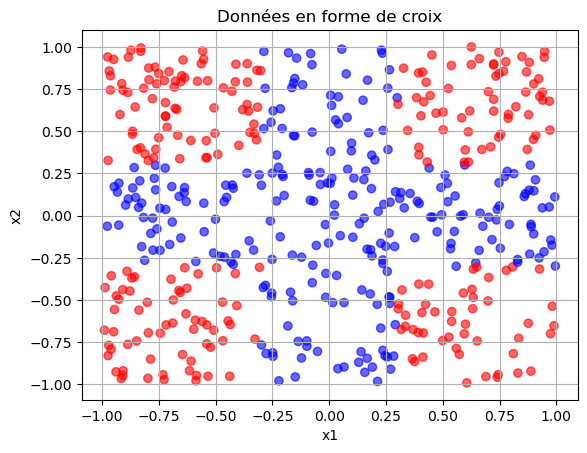

Précision : 50.00%


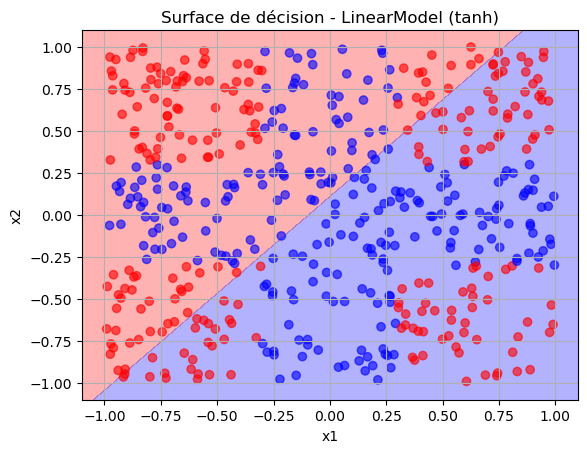

<Figure size 640x480 with 0 Axes>

In [7]:
# Génération des données
X = np.random.random((500, 2)) * 2.0 - 1.0  # Points dans [-1, 1] x [-1, 1]

# Étiquette : +1 si dans une bande horizontale ou verticale
Y = np.array([1 if abs(p[0]) <= 0.3 or abs(p[1]) <= 0.3 else -1 for p in X], dtype=np.float64)

# Affichage
colors = ['blue' if y == 1 else 'red' for y in Y]
plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.6)
plt.title("Données en forme de croix")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.show()
plt.clf()

n_samples, n_features = X.shape

# === Créer le modèle 
X_flat = X.flatten()
Y_flat = Y

model_ptr = lib.create_linear_model_least_squares(
    X_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    Y_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    n_samples,
    n_features
)

# === prédiction
activation_id = 1

Y_pred = np.array([
    lib.predict_linear_model_least_squares_with_activation(
        model_ptr,
        row.astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        n_features,
        activation_id
    )
    for row in X
])
# Fonction de prédiction
def predict(x):
    x_np = np.array(x, dtype=np.float64)
    return lib.predict_linear_model_least_squares_with_activation(
        model_ptr,
        x_np.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        len(x_np),
        1  # tanh
    )

accuracy = (Y_true == Y_pred_binary).sum() / len(Y_true)
print(f"Précision : {accuracy * 100:.2f}%")

# Affichage de la surface de décision
x_min, x_max = -1.1, 1.1
y_min, y_max = -1.1, 1.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([predict(pt) for pt in grid]).reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.3, colors=["red", "blue"])
plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.6)
plt.title("Surface de décision - LinearModel (tanh)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.show()
plt.clf()

